In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [3]:
MAX_SENT_LENGTH = 50
MAX_SENTS = 30
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
cd /content/drive/My Drive

/content/drive/My Drive


In [6]:
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import os
import sys
import pickle
import itertools
import gensim
from sklearn.model_selection import train_test_split
from numpy import zeros
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from gensim.models import Word2Vec

In [7]:
reviews_df = pd.read_csv('Hotel_Reviews.csv')
print(reviews_df.dtypes)
reviews_df = reviews_df.dropna()
reviews_df = reviews_df.reset_index(drop=True)
print('Shape of dataset ',reviews_df.shape)
print(reviews_df.columns)

Hotel_Address                                  object
Additional_Number_of_Scoring                    int64
Review_Date                                    object
Average_Score                                 float64
Hotel_Name                                     object
Reviewer_Nationality                           object
Negative_Review                                object
Review_Total_Negative_Word_Counts               int64
Total_Number_of_Reviews                         int64
Positive_Review                                object
Review_Total_Positive_Word_Counts               int64
Total_Number_of_Reviews_Reviewer_Has_Given      int64
Reviewer_Score                                float64
Tags                                           object
days_since_review                              object
lat                                           float64
lng                                           float64
dtype: object
Shape of dataset  (512470, 17)
Index(['Hotel_Address', 'Additional_N

In [8]:
def clean(text):
    '''
    '''
    text = text.lower()
    text = text.replace("ain't", "am not")
    text = text.replace("aren't", "are not")
    text = text.replace("can't", "cannot")
    text = text.replace("can't've", "cannot have")
    text = text.replace("'cause", "because")
    text = text.replace("could've", "could have")
    text = text.replace("couldn't", "could not")
    text = text.replace("couldn't've", "could not have")
    text = text.replace("should've", "should have")
    text = text.replace("should't", "should not")
    text = text.replace("should't've", "should not have")
    text = text.replace("would've", "would have")
    text = text.replace("would't", "would not")
    text = text.replace("would't've", "would not have")
    text = text.replace("didn't", "did not")
    text = text.replace("doesn't", "does not")
    text = text.replace("don't", "do not")
    text = text.replace("hadn't", "had not")
    text = text.replace("hadn't've", "had not have")
    text = text.replace("hasn't", "has not")
    text = text.replace("haven't", "have not")
    text = text.replace("haven't", "have not")
    text = text.replace("haven't", "have not")
    text = text.replace("haven't", "have not")
    text = text.replace("he'd", "he would")
    text = text.replace("haven't", "have not")
    text = text.replace("he'd've", "he would have")
    text = text.replace("'s", "")
    text = text.replace("'t", "")
    text = text.replace("'ve", "")
    text = text.replace(".", " . ")
    text = text.replace("!", " ! ")
    text = text.replace("?", " ? ")
    text = text.replace(";", " ; ")
    text = text.replace(":", " : ")
    text = text.replace(",", " , ")
    text = text.replace("´", "")
    text = text.replace("‘", "")
    text = text.replace("’", "")
    text = text.replace("“", "")
    text = text.replace("”", "")
    text = text.replace("\'", "")
    text = text.replace("\"", "")
    text = text.replace("-", "")
    text = text.replace("–", "")
    text = text.replace("—", "")
    text = text.replace("[", "")
    text = text.replace("]","")
    text = text.replace("{","")
    text = text.replace("}", "")
    text = text.replace("/", "")
    text = text.replace("|", "")
    text = text.replace("(", "")
    text = text.replace(")", "")
    text = text.replace("$", "")
    text = text.replace("+", "")
    text = text.replace("*", "")
    text = text.replace("%", "")
    text = text.replace("#", "")
    text = text.replace("\n", " \n ")
    text = text.replace("\n", "")
    text = text.replace("_", " _ ")
    text = text.replace("_", "")
    text = ''.join([i for i in text if not i.isdigit()])

    return text

positive_reviews = reviews_df['Positive_Review'].values
negative_reviews = reviews_df['Negative_Review'].values

cleaned_positive_reviews = [clean(r) for r in positive_reviews] 
cleaned_negative_reviews = [clean(r) for r in negative_reviews] 

reviews_df['Positive_Review'] = cleaned_positive_reviews
reviews_df['Negative_Review'] = cleaned_negative_reviews

In [9]:
# Shuffling data
reviews_df = reviews_df.sample(frac=1).reset_index(drop=True)

# Extracting all text
positive_reviews = reviews_df['Positive_Review'].values
negative_reviews = reviews_df['Negative_Review'].values
reviews_text = []

for p,n in zip(positive_reviews, negative_reviews) : 
    if p in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] : 
        reviews_text.append(n)
    elif n in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] : 
        reviews_text.append(p)
    else : 
        reviews_text.append(n)
        reviews_text.append(p)



In [10]:
# Preprocessing training data
training_df = reviews_df.loc[:10000]
positive_reviews_filtered = training_df['Positive_Review'].values
negative_reviews_filtered = training_df['Negative_Review'].values
training_reviews = []
labels = []

for idx,(p,n) in enumerate(zip(positive_reviews_filtered, negative_reviews_filtered)) : 
    if p in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] : 
        training_reviews.append(n)
        labels.append(0)
    elif n in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] :
        training_reviews.append(p)
        labels.append(1)
    else :
        training_reviews.append(n)
        labels.append(0)
        training_reviews.append(p)
        labels.append(1)

# Creating datasets
dict1 ={
    'reviews' : training_reviews,
    'labels' : labels
}
sentiment_df = pd.DataFrame.from_dict(dict1)


dict2 ={
    'reviews_text' : reviews_text
}
reviews_text_df = pd.DataFrame.from_dict(dict2)

In [11]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
%matplotlib inline

Using Theano backend.


In [12]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [13]:
MAX_SENT_LENGTH = 50
MAX_SENTS = 15
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [14]:
sentiment_df = sentiment_df.dropna()
sentiment_df = sentiment_df.reset_index(drop=True)
print('Shape of dataset ',sentiment_df.shape)
print(sentiment_df.columns)
print('No. of unique classes',len(set(sentiment_df['labels'])))

Shape of dataset  (16866, 2)
Index(['reviews', 'labels'], dtype='object')
No. of unique classes 2


In [15]:
import nltk
from nltk import tokenize

reviews = []
labels = []
texts = []

In [16]:
macronum=sorted(set(sentiment_df['labels']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

In [17]:
def fun(i):
    return macro_to_id[i]

sentiment_df['labels']=sentiment_df['labels'].apply(fun)

In [18]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [19]:
for i in range(sentiment_df.reviews.shape[0]):
    text = BeautifulSoup(sentiment_df.reviews[i])
    text=clean_str(str(text.get_text().encode()).lower())
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)


for i in sentiment_df['labels']:
    labels.append(i)

In [20]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j< MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                if k<MAX_SENT_LENGTH and tokenizer.word_index[word]<MAX_NB_WORDS:
                    data[i,j,k] = tokenizer.word_index[word]
                    k=k+1

In [21]:
word_index = tokenizer.word_index
print('No. of %s unique tokens.' % len(word_index))

No. of 11841 unique tokens.


In [22]:
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
#labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

Shape of data tensor: (16866, 15, 50)
Shape of label tensor: (16866, 2)


In [23]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [24]:
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [25]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SENT_LENGTH,
                            trainable=True)

In [26]:
model = tf.keras.Sequential([
      tf.keras.layers.                       
])

SyntaxError: ignored

In [27]:
sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(LSTM(50))(embedded_sequences)
sentEncoder = Model(sentence_input, l_lstm)

review_input = Input(shape=(MAX_SENTS,MAX_SENT_LENGTH), dtype='int32')
review_encoder = TimeDistributed(sentEncoder)(review_input)
l_lstm_sent = Bidirectional(LSTM(50))(review_encoder)
preds = Dense(len(macronum), activation='softmax')(l_lstm_sent)
model = Model(review_input, preds)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Hierachical LSTM")
model.summary()

Hierachical LSTM
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 15, 50)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 100)           1244600   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 1,305,202
Trainable params: 1,305,202
Non-trainable params: 0
_________________________________________________________________


In [28]:
cp=ModelCheckpoint('model_han_.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=5, batch_size=1028,callbacks=[cp])

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Train on 13493 samples, validate on 3373 samples
Epoch 1/5
13493/13493 [==============================] - 576s 43ms/step - loss: 0.7460 - acc: 0.5346 - val_loss: 0.7158 - val_acc: 0.5574

Epoch 00001: val_acc improved from -inf to 0.55737, saving model to model_han_.hdf5
Epoch 2/5
13493/13493 [==============================] - 573s 42ms/step - loss: 0.6971 - acc: 0.5324 - val_loss: 0.6902 - val_acc: 0.5574

Epoch 00002: val_acc did not improve from 0.55737
Epoch 3/5
13493/13493 [==============================] - 569s 42ms/step - loss: 0.6930 - acc: 0.5321 - val_loss: 0.6871 - val_acc: 0.5574

Epoch 00003: val_acc did not improve from 0.55737
Epoch 4/5
13493/13493 [==============================] - 565s 42ms/step - loss: 0.6906 - acc: 0.5380 - val_loss: 0.6864 - val_acc: 0.5574

Epoch 00004: val_acc did not improve from 0.55737
Epoch 5/5
13493/13493 [==============================] - 561s 42ms/step - loss: 0.6899 - acc: 0.5404 - val_loss: 0.6970 - val_acc: 0.4503

Epoch 00005: val_acc d

In [29]:
import keras

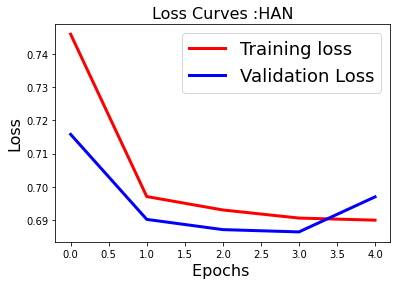

In [30]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :HAN',fontsize=16)
fig1.savefig('loss_han.png')
plt.show()

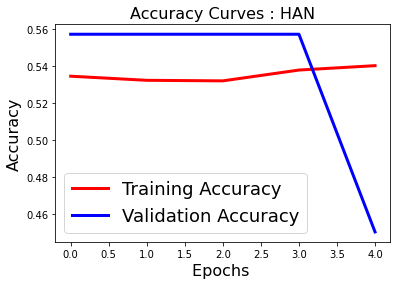

In [31]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : HAN',fontsize=16)
fig2.savefig('accuracy_han.png')
plt.show()

In [ ]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='han_model.png', show_shapes=True, show_layer_names=True)

In [35]:
loss, accuracy = model.evaluate(x_val,y_val)
print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(accuracy))

3373/3373 [==============================] - 44s 13ms/step
Test Loss: 0.6969596620416062
Test Accuracy: 0.45034095644950867
